# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from ryp import r, to_py

In [3]:
r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [4]:
columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [5]:
def polys_to_df(polys):
    poly_labels = list(polys)
    poly_coords = list(polys.values())
    poly_coord_dim = np.shape(poly_coords[0])[-1]
    poly_df = pd.concat(
        [
            pd.DataFrame(
                poly_coords[i], columns=[f"V{i}" for i in range(poly_coord_dim)]
            ).assign(vertex=lambda df: df.index + 1, id=i, label=poly_labels[i])
            for i in range(len(polys))
        ],
        ignore_index=True,
    )
    return poly_df

In [6]:
poly_df = polys_to_df(polys)

In [7]:
columb["label"] = columb["district"]
poly_df = columb.merge(poly_df, on="label")

In [8]:
def plot_polys(df, color, polys, label):
    poly_df = polys_to_df(polys)
    df["label"] = df[label]
    plot_df = df.merge(poly_df, on="label")
    p = (
        p9.ggplot(plot_df)
        + p9.aes("V0", "V1", group="label", fill=color)
        + p9.geom_polygon()
    )
    return p

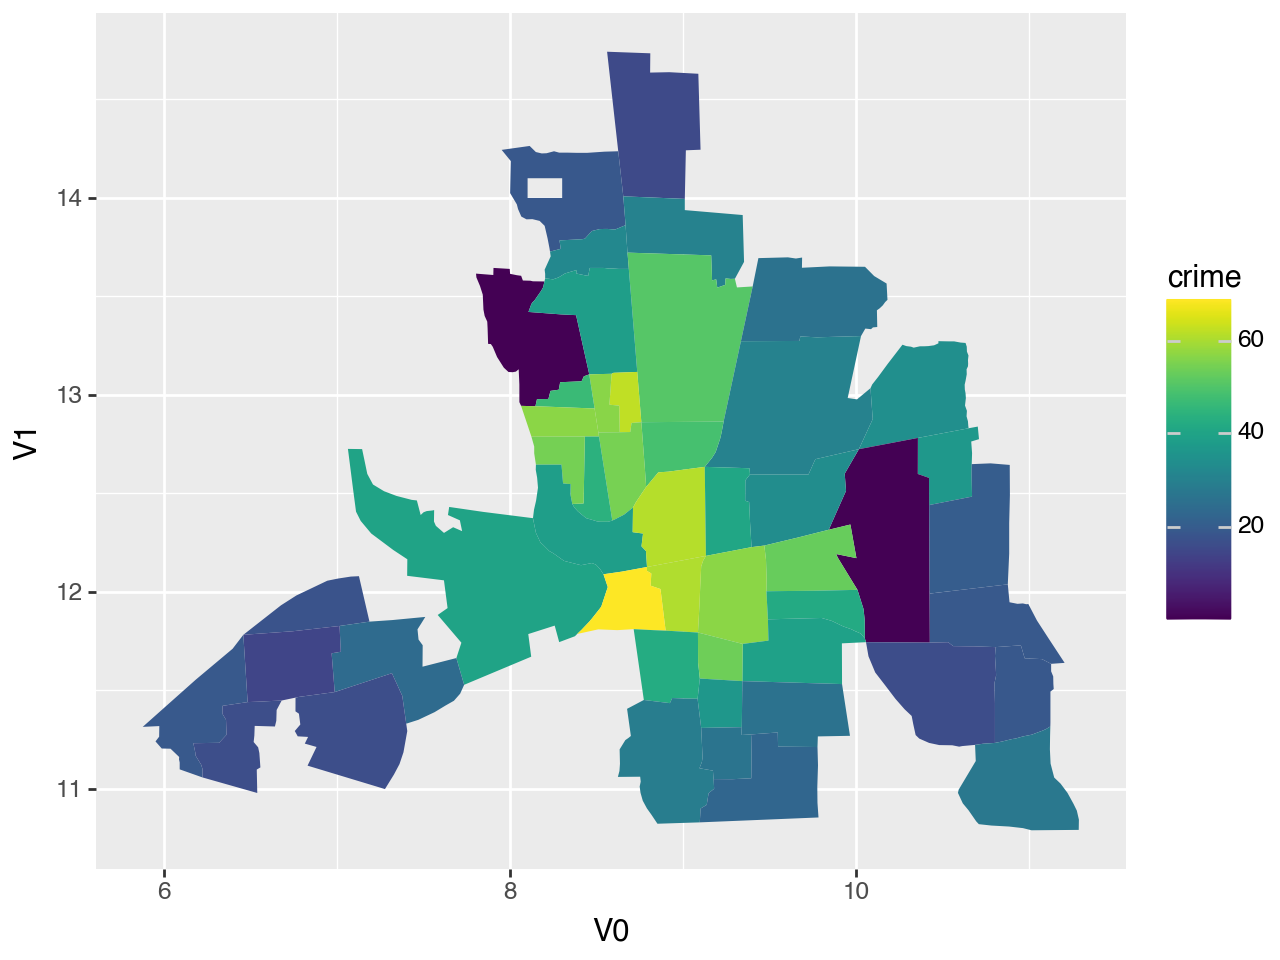

In [9]:
plot_polys(columb, "crime", polys, "district")

## Model Definition

### Setup response model

In [10]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
df.columns

Index(['index', 'area', 'home.value', 'income', 'crime', 'open.space',
       'district', 'x', 'y', 'label'],
      dtype='object')

In [13]:
loc += tb.fo("area"), tb.vc("area", tb.ps("income", scale=1.0))

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


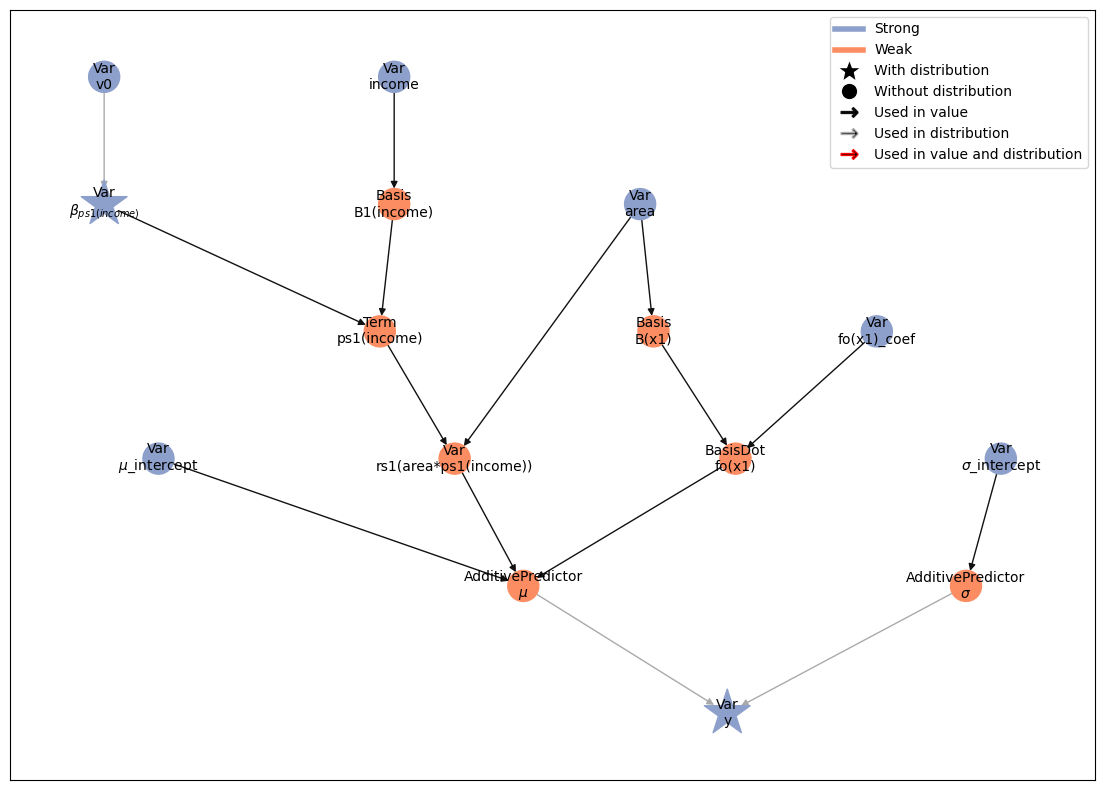

In [14]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [15]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ps1(income)}$', 'fo(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.19chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1307.45chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1343.90chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - S

### MCMC summary

In [16]:
summary = gs.Summary(results)
summary

Parameter summary:

                                kernel       mean         sd     q_0.05  \
parameter             index                                               
$\beta_{ps1(income)}$ (0,)   kernel_02  -0.017041   1.005140  -1.695724   
                      (1,)   kernel_02   0.004323   1.008730  -1.688086   
                      (2,)   kernel_02  -0.006156   0.989219  -1.634072   
                      (3,)   kernel_02   0.006050   0.986724  -1.589285   
                      (4,)   kernel_02  -0.016680   0.988345  -1.635443   
                      (5,)   kernel_02  -0.033598   0.992605  -1.660588   
                      (6,)   kernel_02  -0.018437   1.013386  -1.651243   
                      (7,)   kernel_02  -0.026744   0.969078  -1.625545   
                      (8,)   kernel_02   0.012973   1.003825  -1.640678   
                      (9,)   kernel_02   0.040622   1.019711  -1.617988   
                      (10,)  kernel_02   0.041093   1.000145  -1.602983   
                      (11,)  kernel_02  -0.033002   0.998993  -1.709235   
                      (12,)  kernel_02  -0.023216   0.988000  -1.664245   
                      (13,)  kernel_02  -0.113448   0.991577  -1.747315   
                      (14,)  kernel_02  -0.184439   0.984074  -1.798083   
                      (15,)  kernel_02  -0.230327   0.984781  -1.871872   
                      (16,)  kernel_02   0.648062   0.938808  -0.879880   
                      (17,)  kernel_02   0.675485   0.687413  -0.463166   
                      (18,)  kernel_02 -11.199864   2.843119 -15.861211   
$\mu$_intercept       ()     kernel_01  43.536007   3.358394  38.013159   
$\sigma$_intercept    ()     kernel_00   2.580148   0.106398   2.411630   
fo(x1)_coef           (0,)   kernel_03 -35.820210  15.234740 -60.560727   

                                 q_0.5     q_0.95  sample_size     ess_bulk  \
parameter             index                                                   
$\beta_{ps1(income)}$ (0,)   -0.007136   1.631654         4000  3588.395597   
                      (1,)    0.026638   1.636846         4000  3569.101422   
                      (2,)   -0.017613   1.605809         4000  3384.673870   
                      (3,)    0.007579   1.604254         4000  3292.068278   
                      (4,)   -0.017565   1.642629         4000  3717.128454   
                      (5,)   -0.028457   1.618918         4000  3523.706347   
                      (6,)   -0.024878   1.611973         4000  3466.472485   
                      (7,)   -0.033426   1.579765         4000  3836.049690   
                      (8,)    0.017879   1.661604         4000  2943.796215   
                      (9,)    0.048088   1.682534         4000  3586.905143   
                      (10,)   0.031496   1.647283         4000  3270.788606   
                      (11,)  -0.016085   1.595872         4000  3503.953036   
                      (12,)  -0.018124   1.633957         4000  3664.084070   
                      (13,)  -0.104845   1.500879         4000  3431.217920   
                      (14,)  -0.183457   1.402010         4000  3507.827502   
                      (15,)  -0.212890   1.320558         4000  2995.815194   
                      (16,)   0.653186   2.201374         4000  3373.975781   
                      (17,)   0.685932   1.816057         4000  3220.941129   
                      (18,) -11.237850  -6.515845         4000  3018.391082   
$\mu$_intercept       ()     43.568546  49.014632         4000  3423.462792   
$\sigma$_intercept    ()      2.576766   2.760765         4000  3534.452373   
fo(x1)_coef           (0,)  -35.868176 -10.916432         4000  3284.107515   

                                ess_tail      rhat  
parameter             index                         
$\beta_{ps1(income)}$ (0,)   3809.942889  1.000032  
                      (1,)   3858.044929  0.999865  
                      (2,)   3630.206376  1.000290  
                 

## Plots

In [17]:
samples = results.get_posterior_samples()

In [18]:
from liesel_gam.plots import plot_1d_smooth

In [19]:
list(model.vars)

['y',
 '$\\sigma$',
 '$\\sigma$_intercept',
 '$\\mu$',
 '$\\mu$_intercept',
 'rs1(area*ps1(income))',
 'ps1(income)',
 '$\\beta_{ps1(income)}$',
 'v0',
 'B1(income)',
 'income',
 'area',
 'fo(x1)',
 'fo(x1)_coef',
 'B(x1)']

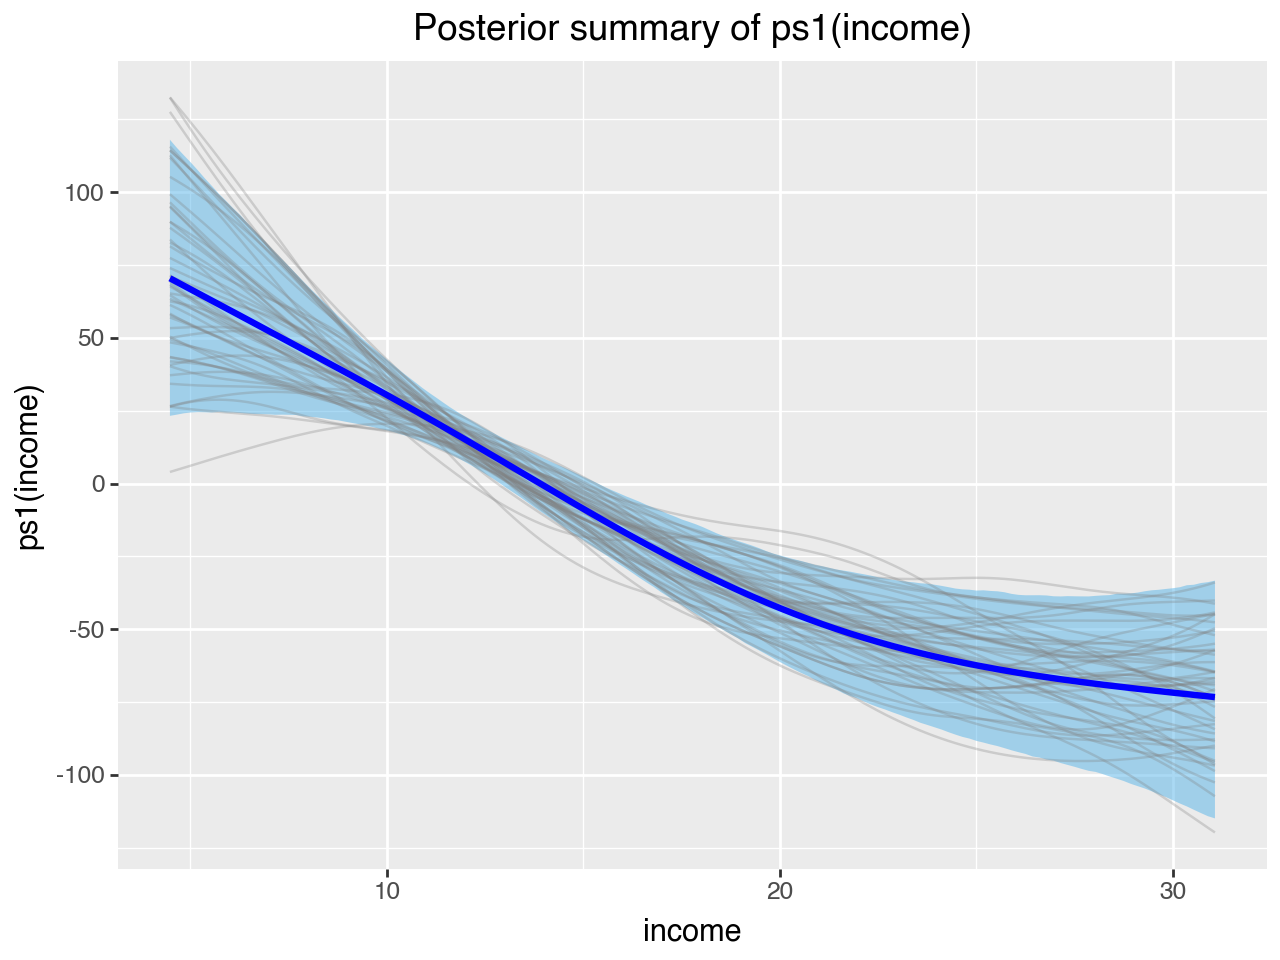

In [20]:
plot_1d_smooth(model.vars["ps1(income)"], samples)